<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/1_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Neural Network with PyTorch. Original source can be found [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [1]:
import torch
import torch.nn.functional as F
from torch import optim 
import torchvision
import matplotlib.pyplot as plt
from time import time
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


# Network
TwoLayerNet with configurable activation function

In [2]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, activation_function: F.log_softmax):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.activation_function = F.log_softmax

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # Relu von pytorch
        h_relu = F.relu(self.linear1(x))
        #h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return self.activation_function(y_pred)

# DATA LOADER

Using QMNIST, because MNIST is not reachable

In [3]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.QMNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.QMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True
)


Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Processing...


# Preprocessing

Showing the data size and sample data

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([1000, 1, 28, 28])


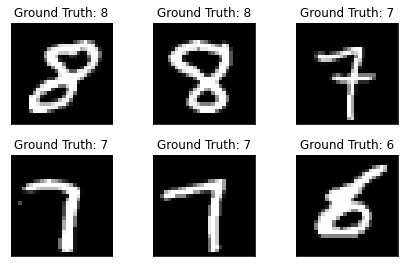

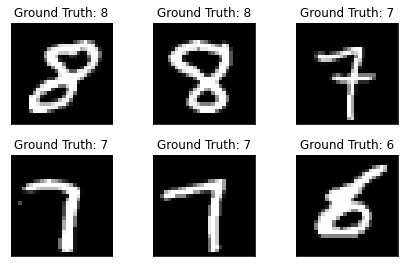

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
# get data and labels from train_loader
x, y = next(iter(train_loader))
print(x.shape)
# Flatten tensor
print(x.view(x.shape[0], -1).shape)
#print(x.flatten().shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


# Train
Method to train the model with configurable parameters

In [7]:
def train(model, epoch: int, loss_function: torch.nn.functional, optimizer: torch.optim, device: torch.device, log_interval: int = 100):
    """Forward pass: Compute predicted y by passing x to the model
    """ 
    global train_losses, train_counter

    for batch_idx, (x, y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      x = x.view(x.shape[0], -1)
      optimizer.zero_grad()
      y_pred = model(x)
      
      # Compute and print loss
      loss = loss_function(y_pred, y)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(x), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

# Test
Method to test model with data from test loader

In [8]:
def test(model, device):
  global test_losses
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      x = x.view(x.shape[0], -1)
      y_hat = model(x)
      test_loss += F.nll_loss(y_hat, y, reduction='sum').item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## PLOT

Plots the Loss of Train and Test

In [9]:
def plot():
    global train_losses, train_counter, test_losses, test_counter

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')

    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

# Execute

Rerunnable Execution of training and test

In [10]:
def run(device_name: str, input_size: int, hidden_size: int, output_size: int, n_epochs: int = 50, activation_function: F = F.log_softmax, loss_function: F = F.nll_loss):
    # INITIATE VARIABLE
    global train_losses, train_counter, test_losses, test_counter
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [0, n_epochs*len(train_loader.dataset)] #[i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    device = torch.device(device_name)

    out = """
    DEVICE: {}
    EPOCHS: {}
    INPUT_SIZE: {}
    HIDDEN_SIZE: {}
    OUTPUT_SIZE: {}
    ACTIVATION_FUNCTION: {}
    LOSS_FUNCTION: {}
    """.format(device_name, n_epochs, input_size, hidden_size, output_size, activation_function, loss_function)

    print(out)

    # Construct our model by instantiating the class defined above
    model = TwoLayerNet(input_size, hidden_size, output_size, activation_function)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

    # TRAIN
    test(model, device)
    time_start = time()
    for epoch in range(1, n_epochs + 1):
      train(model, epoch, loss_function, optimizer, device)
      print("Training Time (in minutes) =",(time()-time_start)/60)

    test(model, device)
    plot()

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []

## CPU


    DEVICE: cpu
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fc73d1d9cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fc73d1dca70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.2981, Accuracy: 8548/60000 (14%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299794
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.290411
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.207123
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.230715
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.242344
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.230634
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.194356
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.185364
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.147819
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.122931
Training Time (in minutes) = 0.13120779991149903
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.169740
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.078500
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.119097
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.153991
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.088657
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.075148
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.081288
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.148448
Train 

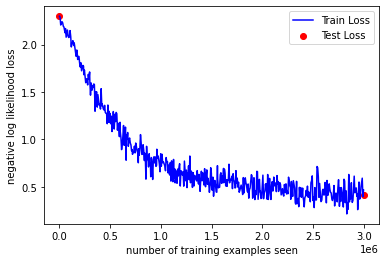

In [12]:
run(
    device_name="cpu",
    input_size=784,
    hidden_size=100,
    output_size=10,
    n_epochs=50,
)

## GPU (CUDA)


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fc73d1d9cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fc73d1dca70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3583, Accuracy: 4266/60000 (7%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.386245
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.356502
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.347607
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.315425
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.275061
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.284390
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.255741
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.281000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.240155
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.238674
Training Time (in minutes) = 0.1289281129837036
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.209447
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.183052
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.172160
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.150676
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.133073
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.145453
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.090612
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.092484
Train Ep

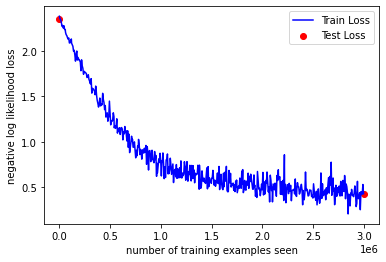

In [13]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=100,
    output_size=10,
    n_epochs=50,
)

## Hidden Layers


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 200
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fc73d1d9cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fc73d1dca70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3404, Accuracy: 5159/60000 (9%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.417129
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.338355
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.303692
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.265438
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.250090
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.236394
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.237402
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.183059
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.192430
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.163990
Training Time (in minutes) = 0.12718998591105143
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.154894
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.186259
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.114286
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.098519
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.124583
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.104070
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.997229
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.024116
Train E

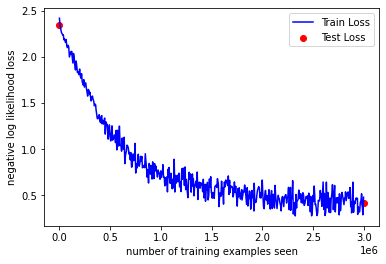

In [14]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=200,
    output_size=10
)


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 784
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function log_softmax at 0x7fc73d1d9cb0>
    LOSS_FUNCTION: <function nll_loss at 0x7fc73d1dca70>
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3091, Accuracy: 9122/60000 (15%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317949
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.317610
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.291380
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.226682
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.154277
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.190444
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.163248
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.125260
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.108650
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.031615
Training Time (in minutes) = 0.1296174963315328
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.067956
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.038832
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.994367
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.012448
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.926657
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.961375
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.916246
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.874015
Train E

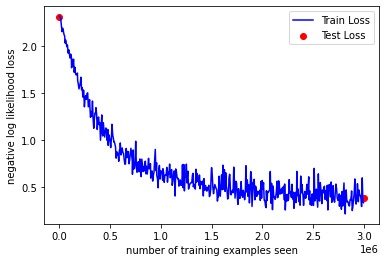

In [15]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=784,
    output_size=10
)

## Softmax


    DEVICE: cuda
    EPOCHS: 50
    INPUT_SIZE: 784
    HIDDEN_SIZE: 100
    OUTPUT_SIZE: 10
    ACTIVATION_FUNCTION: <function softmax at 0x7fc73d1d9c20>
    LOSS_FUNCTION: CrossEntropyLoss()
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3569, Accuracy: 6039/60000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.460632
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.367561
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.371989
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.320849
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.293315
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.247993
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.238490
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.194779
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.209272
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.222980
Training Time (in minutes) = 0.12601179281870525
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.198488
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.127396
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.174190
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.144722
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.086331
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.087554
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.059969
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.059891
Train 

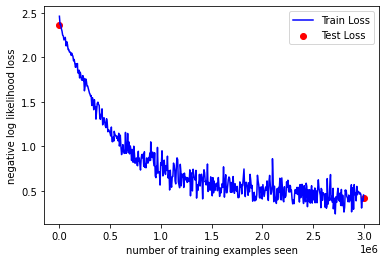

In [16]:
run(
    device_name="cuda",
    input_size=784,
    hidden_size=100,
    output_size=10,
    activation_function=F.softmax,
    loss_function=torch.nn.CrossEntropyLoss()
)